# Analyse ERA5 demand for NEM

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import pickle

import shap
#shap.initjs()

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_WEEKEND = True

In [7]:
REMOVE_XMAS = True

In [8]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [9]:
MASK_NAME = "pop_dens_mask"

In [10]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2016

In [11]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [12]:
N_FEATURES = "parsimonious"

In [13]:
# DETREND = True

In [14]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load model data

In [15]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    detrended=True
)

Days to exclude

In [16]:
# to_exclude = fn.read_results(
#     "predictors_excluded", MARKET, regions, MASK_NAME,
#     FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
#     REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
#     detrended=True
# )

In [119]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    
#     to_exc = xr.Dataset.from_dataframe(to_exclude[r])["0"]
#     to_exc = to_exc.rename({"index": "time"})
    
#     pred_ds[r] = ds.where(to_exc == 0)

    pred_ds[r] = ds

Note:
For features and hyperparameters, we set `detrended=False` because all models are trained on detrended data, so none of them have "_detrended" in the filename

In [18]:
# Population density mask, remove weekends and Xmas
features = fn.read_results(
    "feature_selection", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2017, 2019,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    detrended=False
)

In [19]:
hyperparameters = fn.read_results(
    "hyperparameters", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2017, 2019,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    detrended=False
)

### SHAP analysis

How do the predictors contribute to the predictions for the new training period (2010-2019) and the new test period (1959-2022)?

In [20]:
# write_SHAP = False

In [21]:
# dem_da = xr.open_dataset("/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc")["demand_stl"]

In [22]:
# DETREND = True

# trainX_dict = {}
# testX_dict = {}

# shap_train = {}
# shap_test = {}

# explainer_train = {}
# explainer_test = {}

# for r in regions:
#     cal = fn.get_calendar(MARKET, r)
#     dem = fn.remove_time(dem_da, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).sel(region=r)
#     train_pred = fn.remove_time(pred_ds[r], REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).drop(["demand", "is_workday"])
#     test_pred = pred_ds[r].drop(["demand"])
        
#     train_X = train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))).to_dataframe().values
#     test_X = test_pred.to_dataframe().values
#     train_y = dem.loc[slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))].values
    
#     # Remove rows with NaNs that we introduced earlier
#     test_X = test_X[~np.isnan(test_X).any(axis=1), :]
    
#     # And get dates that we keep
#     to_exc = xr.Dataset.from_dataframe(to_exclude[r])["0"]
#     to_exc = to_exc.rename({"index": "time"})
#     index_keep = test_pred[list(test_pred.data_vars)[0]].where(to_exc == 0).dropna("time").time
    
#     trainX_dict[r] = train_X
#     testX_dict[r] = test_X
    
#     filename_train = fn.get_filename(
#         "SHAP_train", MARKET, r, MASK_NAME,
#         FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
#         REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
#     )
#     if DETREND:
#         filename_train = filename_train + "_detrended"
        
#     filename_test = fn.get_filename(
#         "SHAP_test", MARKET, r, MASK_NAME,
#         FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
#         REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
#     )
#     if DETREND:
#         filename_test = filename_test + "_detrended"
    
#     if write_SHAP:
#         from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
        
#         # Finalise model
#         rf = ExtraTreesRegressor(
#             n_estimators=int(hyperparameters[r].loc["n_estimators"].values),
#             min_samples_leaf=int(hyperparameters[r].loc["min_samples_leaf"].values),
#             max_depth=int(hyperparameters[r].loc["max_depth"].values),
#             max_leaf_nodes=int(hyperparameters[r].loc["max_leaf_nodes"].values),
#             random_state=0,
#         )

#         model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
#         model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)

#         explainer = shap.Explainer(rf)
#         # explain_train = explainer.shap_values(train_X)
#         # explain_test = explainer.shap_values(test_X)
#         explain_train = explainer(train_X)
#         explain_test = explainer(test_X)
        
#         # Pickle entire explainer
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "wb") as f:
#              pickle.dump(explain_train, f)

#         # Write SHAP values separately to csv
#         shap_train[r] = pd.DataFrame(
#             explain_train.values,
#             index=pd.to_datetime(train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR)))["time"].values),
#             columns=list(train_pred.data_vars)
#         )
#         shap_train[r].to_csv(
#             RESULTS_PATH + "/SHAP/random_forest/" + filename_train + ".csv",
#         )

#         # Now for test
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "wb") as f:
#              pickle.dump(explain_test, f)

#         shap_test[r] = pd.DataFrame(
#             explain_test.values,
#             # index=pd.to_datetime(test_pred.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR)))["time"].values),
#             index=pd.to_datetime(index_keep),
#             columns=list(test_pred.data_vars)
#         )

#         shap_test[r].to_csv(
#             RESULTS_PATH + "/SHAP/random_forest/" + filename_test + ".csv",
#         )
        
#     else:
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "rb") as f:
#              explainer_train[r] = pickle.load(f)
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "rb") as f:
#              explainer_test[r] = pickle.load(f)

In [23]:
# def plot_shap(vals, features, feature_names, colorbar=True, fontsize=10):
#     """
#     Custom shap summary plot
#     """
#     pl = shap.summary_plot(
#         vals,
#         features,
#         feature_names=feature_names,
#         # order=order,
#         plot_type="dot",
#         cmap="viridis",
#         color_bar=colorbar,
#         show=False,
#         plot_size=None,
#         sort=False # Don't sort predictor order
#     )

#     ax = plt.gca()
#     for pos in ["top", "bottom", "left", "right"]:
#         ax.spines[pos].set_visible(True)

#     ax.axes.grid(visible=True)
#     ax.axvline(0, c="k")
#     ax.set_xlabel("SHAP value " + r"[GWh d$^{-1}$]", fontsize=fontsize)
    
#     ax.yaxis.label.set_size(fontsize)
#     ax.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)
    
#     return ax

In [24]:
# fig = plt.figure(figsize=(7,4))

# for i, r in enumerate(regions):
    
#     # Ensure default predictor order is retained
#     order_features = fn.parse_features(fn.sel_model(features[r])["feature_names"])[::-1]
#     # col2num = {col: i for i, col in enumerate(order_features)}
#     # order = list(map(col2num.get, order_features))
    
#     fig.add_subplot(2, 3, i+1)
#     a = plot_shap(
#         explainer_test[r].values / 1000,
#         testX_dict[r],
#         order_features,
#         # order=order,
#         colorbar=False
#     )
#     a.set_title(r)
#     # a.text(0.8, 0.05, r, transform=a.transAxes)
    
#     if i in [0, 1, 2]:
#         a.set_xlabel("")

# plt.subplots_adjust(wspace=0.75, hspace=0.35)
    
# # Figure legend
# cmap = plt.get_cmap('viridis')
# cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=100)
# scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
# scalarMap.set_array([])

# cax = fig.add_axes([0.26, 0.0, 0.5, 0.04])
# cbar = fig.colorbar(scalarMap, cax=cax, ticks=[0, 100], orientation="horizontal")
# cbar.ax.set_xticklabels(["Low", "High"])
# cbar.ax.set_xlabel("Feature value")

### Compare statistics of train (2010-2016) vs test (1959-2022)

In [25]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [26]:
def plot_hist(ax, histograms, labels, xlabel, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    linestyles = ["--", "-"]
    for hist, label, color, ls in zip(histograms, labels, colors, linestyles):
        hist.plot(ax=ax, color=color, label=label, ls=ls)
    ax.set_ylabel(r"Density [d GWh$^{-1}$]")
    ax.set_xlabel(xlabel)

In [27]:
first_vars = [predictions[r].columns[0] for r in regions]

In [28]:
first_vars

['t2max', 't2max', 't2max', 't2max', 't2max', 't2m']

In [29]:
# first_vars_units = ["[deg C]", "[deg C]", "[deg C]", "[deg C]", "[deg C]", r"[W m$^{-2}$]"]

In [30]:
first_vars_units = [r"[$^{\circ}$C]", r"[$^{\circ}$C]", r"[$^{\circ}$C]",
                    r"[$^{\circ}$C]", r"[$^{\circ}$C]", r"[$^{\circ}$C]"]

In [31]:
second_vars = [predictions[r].columns[1] for r in regions]
second_vars

['msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'w10']

In [32]:
# second_vars_units = [r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", "[deg C]"]

In [33]:
second_vars_units = [r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[ms$^{-1}$]"]

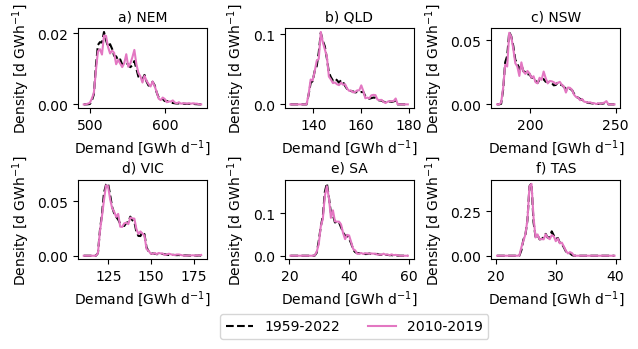

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

letters = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) "]

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000)
    ]
    plot_hist(ax.flatten()[i], hists, ["1959-2022", "2010-2019"],
              r"Demand [GWh d$^{-1}$]", colors=["k", "tab:pink"])     
    
    ax.flatten()[i].set_title(letters[i] + r, fontsize=10)
    
ax[1,1].legend(loc=(-0.5, -1), ncols=2)
plt.subplots_adjust(wspace=0.6, hspace=0.9)

plt.savefig("figures/demand_long_vs_short.pdf", format="pdf", bbox_inches="tight")

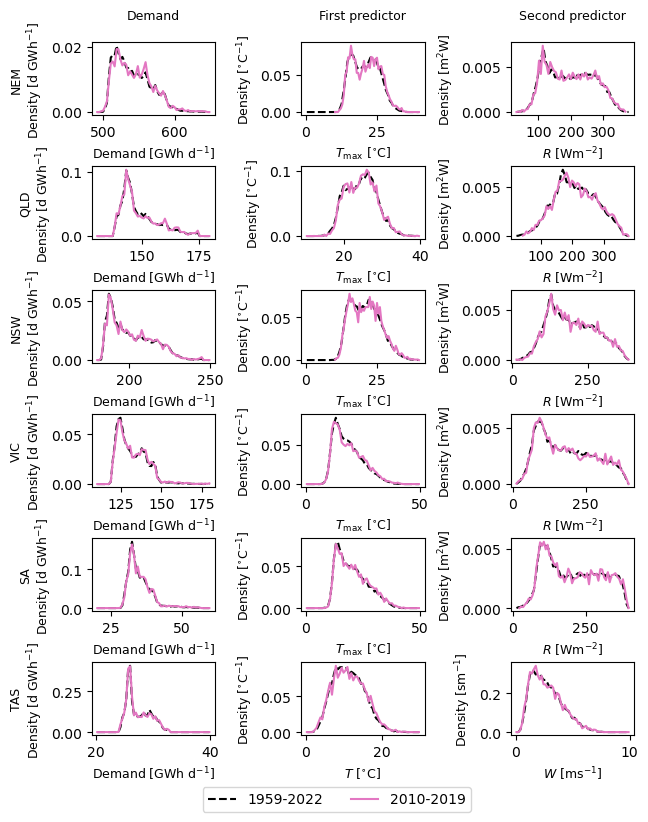

In [75]:
fig, ax = plt.subplots(6, 3, figsize=(7,9))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000)
    ]
    plot_hist(ax[i,0], hists, ["1959-2022", "2010-2019"],
              r"Demand [GWh d$^{-1}$]", colors=["k", "tab:pink"])   

    # Most important variable histograms
    if first_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("1959", "2022")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("2010", "2019")) + offset)
    ]
    plot_hist(ax[i,1], hists, ["1959-2022", "2010-2019"],
             first_vars[i] + " " + first_vars_units[i], colors=["k", "tab:pink"])  
    
    # Second most important variable histograms
    if second_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("1959", "2022")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("2010", "2019")) + offset)
    ]
    plot_hist(ax[i,2], hists, ["1959-2022", "2010-2019"],
             second_vars[i] + " " + second_vars_units[i], colors=["k", "tab:pink"])  
    
    if i == 0:
        ax[i,0].set_title("Demand\n", fontsize=9)
        ax[i,1].set_title("First predictor\n", fontsize=9)
        ax[i,2].set_title("Second predictor\n", fontsize=9)
    else:
        ax[i,0].set_title("")
        ax[i,1].set_title("")
        ax[i,2].set_title("")
        
    ax[i,0].set_ylabel(r + "\n" + r"Density [d GWh$^{-1}$]", fontsize=9)
    ax[i,1].set_ylabel(r"Density [$^{\circ}$C$^{-1}$]", fontsize=9)
    if i < 5:
        ax[i,2].set_ylabel(r"Density [m$^{2}$W]", fontsize=9)
    else:
        ax[i,2].set_ylabel(r"Density [sm$^{-1}$]", fontsize=9)
        
    ax[i,0].set_xlabel(r"Demand [GWh d$^{-1}$]", fontsize=9)
    if i < 5:
        ax[i,1].set_xlabel(r"$T_{\mathrm{max}}$ [$^{\circ}$C]", fontsize=9)
    else:
        ax[i,1].set_xlabel(r"$T$ [$^{\circ}$C]", fontsize=9)
    if i < 5:
        ax[i,2].set_xlabel(r"$R$ [Wm$^{-2}$]", fontsize=9)
    else:
        ax[i,2].set_xlabel(r"$W$ [ms$^{-1}$]", fontsize=9)
        
    if i == 5:
        ax[i,0].legend(ncols=2, loc=(0.9, -1.05))
        
plt.subplots_adjust(wspace=0.7, hspace=0.7)

plt.savefig("figures/predictor_target_pdfs.pdf", format="pdf", bbox_inches="tight")

### Distributions during ENSO events

Load Nino3.4 HadISST

In [34]:
nino34_monthly= xr.open_zarr(
    "/g/data/w42/dr6273/work/data/hadisst/climate_modes/hadisst_nino34_1959-2022.zarr",
    consolidated=True
).nino34_detrended.compute()

In [35]:
nino34 = nino34_monthly.resample(time="1D").pad() # Set daily values as for each month

In [36]:
# Custom December 2022 series to concat
dec22 = xr.DataArray(
    np.repeat(nino34.values[-1], 30),
    dims=["time"],
    coords={"time": pd.date_range("2022-12-02", "2022-12-31")}
)

In [37]:
nino34 = xr.concat([nino34, dec22], dim="time")

In [38]:
# 3-month rolling mean
nino34 = nino34.rolling(time=3).mean()

In [39]:
# nino34_ond = nino34.isel(time=nino34.time.dt.month.isin([10, 11, 12]))

In [40]:
def sel_enso(demand, enso, enso_type, period):
    """
    Select demand data for El Nino or La Nina events.
    
    demand: demand array
    enso: enso index array
    enso_type: str, "EN" or "LN"
    period: slice
    """
    if enso_type == "EN":
        return demand.where(enso > 0.8).sel(time=period)
    elif enso_type == "LN":
        return demand.where(enso < -0.8).sel(time=period)
    else:
        raise ValueError("Incorrect enso_type")

In [41]:
# fig, ax = plt.subplots(2, 3, figsize=(7,3))

# for i, r in enumerate(regions):
#     # Demand histograms
#     hists = [
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34, "EN", slice("2010", "2019")) / 1000),
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34, "EN", slice("1959", "2022")) / 1000)
#     ]
#     plot_hist(ax.flatten()[i], hists, ["2010-2019", "1959-2022"], "Demand [GWh / day]")     
    
#     ax.flatten()[i].set_title(r)
    
# ax[0,2].legend(loc=(0.4, 0.4))
# plt.subplots_adjust(wspace=0.6, hspace=0.9)

In [42]:
# fig, ax = plt.subplots(2, 3, figsize=(7,3))

# for i, r in enumerate(regions):
#     # Demand histograms
#     hists = [
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34_ond, "LN", slice("2010", "2019")) / 1000),
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34_ond, "LN", slice("1959", "2022")) / 1000)
#     ]
#     plot_hist(ax.flatten()[i], hists, ["2010-2019", "1959-2022"], "Demand [GWh / day]")     
    
#     ax.flatten()[i].set_title(r)
    
# ax[0,2].legend(loc=(0.4, 0.4))
# plt.subplots_adjust(wspace=0.6, hspace=0.9)

In [43]:
# fig, ax = plt.subplots(2, 3, figsize=(7,3))

# for i, r in enumerate(regions):
#     # Demand histograms
#     hists = [
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34_ond, "LN", slice("1959", "2022")) / 1000),
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34_ond, "EN", slice("1959", "2022")) / 1000)
#     ]
#     plot_hist(ax.flatten()[i], hists, ["LN", "EN"], "Demand [GWh / day]")     
    
#     ax.flatten()[i].set_title(r)
    
# ax[0,2].legend(loc=(0.4, 0.4))
# plt.subplots_adjust(wspace=0.6, hspace=0.9)

In [44]:
# fig, ax = plt.subplots(2, 3, figsize=(7,3))

# for i, r in enumerate(regions):
#     # Demand histograms
#     hists = [
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34_ond, "LN", slice("2010", "2019")) / 1000),
#         get_hist(sel_enso(pred_ds[r]["demand"], nino34_ond, "EN", slice("2010", "2019")) / 1000)
#     ]
#     plot_hist(ax.flatten()[i], hists, ["LN", "EN"], "Demand [GWh / day]")     
    
#     ax.flatten()[i].set_title(r)
    
# ax[0,2].legend(loc=(0.4, 0.4))
# plt.subplots_adjust(wspace=0.6, hspace=0.9)

### Change in probability between short and long records

In [45]:
def prob(da, q):
    """
    Empirical probability of da > q
    """
    return da.where(da > q).count() / len(da.time)

In [46]:
# def prob_bar_data(q=0.997, enso_type=None, short_period=slice("2000", "2009"), long_period=slice("1959", "1999")):
#     """
#     Get probability of exceeding q in a short and long period.
#     Can condition on enso flavour.
    
#     q: float, quantile of 2010-19 to set as extreme
#     enso_type: str, None, "EN" or "LN"
#     """
#     data = []
#     short_thresh = []
#     long_thresh = []
    
#     for r in regions:
#     # for r in ["VIC"]:
#         if enso_type == "EN":
#             long = pred_ds[r]["demand"].where(nino34 > 0.8).sel(time=long_period).dropna("time")
#             short = pred_ds[r]["demand"].where(nino34 > 0.8).sel(time=short_period).dropna("time")
#         elif enso_type == "LN":
#             long = pred_ds[r]["demand"].where(nino34 < -0.8).sel(time=long_period).dropna("time")
#             short = pred_ds[r]["demand"].where(nino34 < -0.8).sel(time=short_period).dropna("time")
#         elif enso_type is None:
#             long = pred_ds[r]["demand"].sel(time=long_period)
#             short = pred_ds[r]["demand"].sel(time=short_period)
#         else:
#             raise ValueError("Incorrect enso_type")
                    
#         s_thresh = pred_ds[r]["demand"].sel(time=short_period).quantile(0.997)
#         l_thresh = pred_ds[r]["demand"].sel(time=long_period).quantile(0.997)
        
#         short_thresh.append(s_thresh.values)
#         long_thresh.append(l_thresh.values)
        
#         p_short = prob(short, s_thresh) * 100
#         p_long = prob(long, s_thresh) * 100
        
#         data.append(p_short.values)
#         data.append(p_long.values)
        
#     return np.array(data), short_thresh, long_thresh

In [47]:
# probs_q997, short_thresh, long_thresh = prob_bar_data()

In [48]:
# probs_EN_q997, short_thresh_EN, long_thresh_EN = prob_bar_data(enso_type="EN")

In [49]:
# probs_LN_q997, short_thresh_LN, long_thresh_LN = prob_bar_data(enso_type="LN")

In [50]:
# fig, ax = plt.subplots(4, 1, figsize=(7,7))

# col1 = "tab:pink"
# col2 = "tab:blue"

# nino34_monthly.sel(time=slice("2000", "2009")).plot(ax=ax[0], color=col2)
# nino34_monthly.sel(time=slice("1959", "1999")).plot(ax=ax[0], color=col1)
# ax[0].axhline(-0.8, c="k", lw=0.7, ls="--")
# ax[0].axhline(0.8, c="k", lw=0.7, ls="--")
# ax[0].set_yticks([-2.5, 0, 2.5])
# ax[0].set_ylabel(r"Nino3.4 [$^{\circ}$C]")
# ax[0].set_xlabel("")
# ax[0].set_title("a) Nino3.4 index", fontsize=10, loc="left")

# x = [0.2, 0.8, 2.2, 2.8, 4.2, 4.8, 6.2, 6.8, 8.2, 8.8, 10.2, 10.8]

# ax[1].bar(x[1::2], probs_q997[1::2], color=col1, width=0.5, label="1959-1999")
# ax[1].bar(x[::2], probs_q997[::2], color=col2, width=0.5, label="2000-2009")
# ax[1].set_title("b) All days", fontsize=10, loc="left")
# ax[1].legend(frameon=True, loc=(0.5, 1.05), ncols=2)

# ax[2].bar(x[::2], probs_EN_q997[::2], color=col2, width=0.5)
# ax[2].bar(x[1::2], probs_EN_q997[1::2], color=col1, width=0.5)
# ax[2].set_title("c) Days during El Nino months", fontsize=10, loc="left")

# ax[3].bar(x[::2], probs_LN_q997[::2], color=col2, width=0.5)
# ax[3].bar(x[1::2], probs_LN_q997[1::2], color=col1, width=0.5)
# ax[3].set_title("d) Days during La Nina months", fontsize=10, loc="left")

# for a in ax[1:]:
#     a.set_xticks(np.arange(0.5, 11, 2))
#     a.set_xticklabels(regions)
#     a.axhline(0.3, c="k", ls="--", lw=0.9)
#     a.set_ylabel("Probability [%]")
    
# plt.subplots_adjust(hspace=1.1)

In [51]:
# def prob_bar_data_3(
#     q=0.997,
#     enso_type=None,
#     p1=slice("1959", "1999"),
#     p2=slice("2000", "2009"),
#     p3=slice("2010", "2019"),
#     baseline_p=2
# ):
#     """
#     Get probability of exceeding q in a short and long period.
#     Can condition on enso flavour.
    
#     q: float, quantile of 2010-19 to set as extreme
#     enso_type: str, None, "EN" or "LN"
#     p1, p2, p3: slice, periods to compute over
#     baseline_p: int [1, 2, 3], which period to use to compute threshold
#     """
#     data = []
#     p1_thresh = []
#     p2_thresh = []
#     p3_thresh = []
    
#     for r in regions:
#     # for r in ["VIC"]:
#         if enso_type == "EN":
#             d1 = pred_ds[r]["demand"].where(nino34 > 0.8).sel(time=p1).dropna("time")
#             d2 = pred_ds[r]["demand"].where(nino34 > 0.8).sel(time=p2).dropna("time")
#             d3 = pred_ds[r]["demand"].where(nino34 > 0.8).sel(time=p3).dropna("time")
#         elif enso_type == "LN":
#             d1 = pred_ds[r]["demand"].where(nino34 < -0.8).sel(time=p1).dropna("time")
#             d2 = pred_ds[r]["demand"].where(nino34 < -0.8).sel(time=p2).dropna("time")
#             d3 = pred_ds[r]["demand"].where(nino34 < -0.8).sel(time=p3).dropna("time")
#         elif enso_type is None:
#             d1 = pred_ds[r]["demand"].sel(time=p1)
#             d2 = pred_ds[r]["demand"].sel(time=p2)
#             d3 = pred_ds[r]["demand"].sel(time=p3)
#         else:
#             raise ValueError("Incorrect enso_type")
                    
#         d1_thresh = pred_ds[r]["demand"].sel(time=p1).quantile(0.997)
#         d2_thresh = pred_ds[r]["demand"].sel(time=p2).quantile(0.997)
#         d3_thresh = pred_ds[r]["demand"].sel(time=p3).quantile(0.997)
#         thresh_list = [d1_thresh, d2_thresh, d3_thresh]
#         thresh = thresh_list[baseline_p - 1]
        
#         p1_thresh.append(d1_thresh.values)
#         p2_thresh.append(d2_thresh.values)
#         p3_thresh.append(d3_thresh.values)
        
#         prob1 = prob(d1, thresh) * 100
#         prob2 = prob(d2, thresh) * 100
#         prob3 = prob(d3, thresh) * 100
        
#         data.append(prob1.values)
#         data.append(prob2.values)
#         data.append(prob3.values)
        
#     return np.array(data), p1_thresh, p2_thresh, p3_thresh

In [52]:
# probs_q997, _, _, _ = prob_bar_data_3()

In [53]:
# probs_EN_q997, _, _, _ = prob_bar_data_3(enso_type="EN")

In [54]:
# probs_LN_q997, _, _, _ = prob_bar_data_3(enso_type="LN")

In [55]:
# fig, ax = plt.subplots(4, 1, figsize=(7,7))

# col1 = "tab:pink"
# col2 = "tab:blue"
# col3 = "tab:green"

# nino34_monthly.sel(time=slice("1959", "1999")).plot(ax=ax[0], color=col1)
# nino34_monthly.sel(time=slice("2000", "2009")).plot(ax=ax[0], color=col2)
# nino34_monthly.sel(time=slice("2010", "2019")).plot(ax=ax[0], color=col3)
# ax[0].axhline(-0.8, c="k", lw=0.7, ls="--")
# ax[0].axhline(0.8, c="k", lw=0.7, ls="--")
# ax[0].set_yticks([-2.5, 0, 2.5])
# ax[0].set_ylabel(r"Nino3.4 [$^{\circ}$C]")
# ax[0].set_xlabel("")
# ax[0].set_title("a) Nino3.4 index", fontsize=10, loc="left")

# x = [
#     0.2, 0.5, 0.8,
#     2.2, 2.5, 2.8,
#     4.2, 4.5, 4.8,
#     6.2, 6.5, 6.8,
#     8.2, 8.5, 8.8,
#     10.2, 10.5, 10.8
# ]
# bar_width = 0.3

# ax[1].bar(x[::3], probs_q997[::3], color=col1, width=bar_width, label="1959-1999")
# ax[1].bar(x[1::3], probs_q997[1::3], color=col2, width=bar_width, label="2000-2009")
# ax[1].bar(x[2::3], probs_q997[2::3], color=col3, width=bar_width, label="2010-2019")
# ax[1].set_title("b) All days", fontsize=10, loc="left")
# ax[1].legend(frameon=True, loc=(0.25, 1.05), ncols=3)

# ax[2].bar(x[::3], probs_EN_q997[::3], color=col1, width=bar_width)
# ax[2].bar(x[1::3], probs_EN_q997[1::3], color=col2, width=bar_width)
# ax[2].bar(x[2::3], probs_EN_q997[2::3], color=col3, width=bar_width)
# ax[2].set_title("c) Days during El Nino months", fontsize=10, loc="left")

# ax[3].bar(x[::3], probs_LN_q997[::3], color=col1, width=bar_width)
# ax[3].bar(x[1::3], probs_LN_q997[1::3], color=col2, width=bar_width)
# ax[3].bar(x[2::3], probs_LN_q997[2::3], color=col3, width=bar_width)
# ax[3].set_title("d) Days during La Nina months", fontsize=10, loc="left")

# for a in ax[1:]:
#     a.set_xticks(np.arange(0.5, 11, 2))
#     a.set_xticklabels(regions)
#     a.axhline(0.3, c="k", ls="--", lw=0.9)
#     a.set_ylabel("Probability [%]")
    
# plt.subplots_adjust(hspace=1.1)

In [56]:
def prob_decadal_var(
    var="demand",
    q=0.997,
    enso_type=None,
    reference_period=slice("1959", "2022"),
    split_periods=[slice(str(i), str(i+9)) for i in range(1960, 2020, 10)]
):
    """
    Get change in likelihood of event for different periods relative to reference.
    Can condition on enso flavour.
    
    var: str, variable to analyse
    q: float, quantile of 2010-19 to set as extreme
    enso_type: str, None, "EN" or "LN"
    reference_period: slice
    split_periods: list of slices
    """
    results = {r: [] for r in regions}
    
    for r in regions:
        ds = pred_ds[r][var]
        
        # Threshold for reference period
        reference_thresh = ds.sel(time=reference_period).quantile(q).values
        
        # Thresholds for each split
        # split_threshs = [ds.sel(time=p).quantile(q).values for p in split_periods]
        
        # Subset data for El Nino or La Nina, or not
        if enso_type == "EN":
            split_data = [ds.where(nino34 > 0.8).sel(time=p).dropna("time") for p in split_periods]
            # Probability during El Nino over reference period
            enso_prob = prob(
                ds.where(nino34 > 0.8).sel(time=reference_period).dropna("time"),
                reference_thresh
            ) * 100
        elif enso_type == "LN":
            split_data = [ds.where(nino34 < -0.8).sel(time=p).dropna("time") for p in split_periods]
            # Probability during La Nina over reference period
            enso_prob = prob(
                ds.where(nino34 < -0.8).sel(time=reference_period).dropna("time"),
                reference_thresh
            ) * 100
        elif enso_type is None:
            split_data = [ds.sel(time=p).dropna("time") for p in split_periods]
            enso_prob = None
        else:
            raise ValueError("Incorrect enso_type")
            
        # Thresholds for each split
        split_threshs = [da.quantile(q).values for da in split_data]
            
        # Probabilities of exceeding the reference threshold for each split
        split_probs = [prob(s, reference_thresh).values * 100 for s in split_data]
        
        results[r] = {
            "ref_prob": (1 - q) * 100,
            "ref_thresh": reference_thresh,
            "split_probs": split_probs,
            "split_thresh": split_threshs,
            "enso_ref_prob": enso_prob
        }
        
    return results

In [57]:
probs_p99 = prob_decadal_var(q=0.99)

In [58]:
probs_p99_EN = prob_decadal_var(q=0.99, enso_type="EN")

In [59]:
probs_p99_LN = prob_decadal_var(q=0.99, enso_type="LN")

In [60]:
probs_p99_7 = prob_decadal_var()

In [61]:
probs_p99_7_EN = prob_decadal_var(enso_type="EN")

In [62]:
probs_p99_7_LN = prob_decadal_var(enso_type="LN")

In [63]:
def plot_decadal(
    ax,
    data_dict,
    ref_prob,
    # difference_from_enso_ref_prob=False,
    plot_enso_ref_prob=False,
    splits=["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19"],
    markers=["o", "x", "^", "v", "s", "*"],
    remove_zeros=False
):
    """
    Scatter plot decadal probabilities for each region
    """
    cmap = matplotlib.cm.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 0.95, len(splits))]
    
    for i, (split, marker) in enumerate(
        zip(splits, markers)
    ):
        y = [data_dict[r]["split_probs"][i] for r in regions]
        
        # if difference_from_enso_ref_prob:
        #     y = [i - data_dict[r]["enso_ref_prob"]
        
        if remove_zeros:
            y = [i if i != 0 else np.nan for i in y]

        ax.scatter(range(len(regions)), y, color=colors[i], marker=marker, label=split)
        
    if plot_enso_ref_prob:
        y2 = [data_dict[r]["enso_ref_prob"] for r in regions]
        ax.scatter(range(len(regions)), y2, marker="d", color="tab:pink", label="1959-2022")

    ax.axhline(ref_prob, c="k", lw=0.7)
    ax.set_xticks(range(len(regions)))
    ax.set_xticklabels(regions)
    ax.set_ylabel("Probability [%]")
    
    return ax

(0.0, 1.0, 0.0, 1.0)

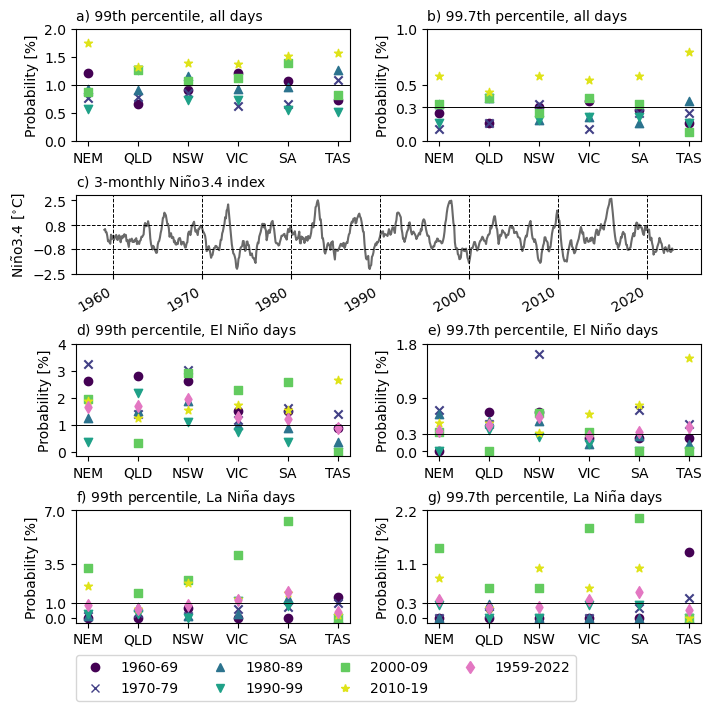

In [81]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 2, height_ratios=[1, 0.7, 1., 1., 0.1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,:])
# axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# All days
plot_decadal(ax1, probs_p99, ref_prob=1)
ax1.set_title("a) 99th percentile, all days", fontsize=10, loc="left")
ax1.set_yticks(np.arange(0, 2.01, 0.5))

plot_decadal(ax2, probs_p99_7, ref_prob=0.3)
ax2.set_title("b) 99.7th percentile, all days", fontsize=10, loc="left")
ax2.set_yticks([0, 0.3, 0.5, 1])

# Nino34
nino34_monthly.sel(time=slice("1959", "2022")).plot(ax=ax3, color="dimgray")
ax3.axhline(-0.8, c="k", lw=0.7, ls="--")
ax3.axhline(0.8, c="k", lw=0.7, ls="--")
ax3.set_yticks([-2.5, -0.8, 0.8, 2.5])
ax3.set_ylabel(r"Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]")
ax3.set_xlabel("")
ax3.set_title(r"c) 3-monthly Ni$\mathrm{\tilde{n}}$o3.4 index", fontsize=10, loc="left")
for d in range(1960, 2021, 10):
    ax3.axvline(pd.to_datetime(str(d) + "-01-01"), c="k", ls="--", lw=0.7)

# El Nino
plot_decadal(ax4, probs_p99_EN, plot_enso_ref_prob=True, ref_prob=1)
ax4.set_title(r"d) 99th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax4.set_yticks(range(5))

plot_decadal(ax5, probs_p99_7_EN, plot_enso_ref_prob=True, ref_prob=0.3)
ax5.set_title(r"e) 99.7th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax5.set_yticks([0, 0.3, 0.9, 1.8])

# La Nina
plot_decadal(ax6, probs_p99_LN, plot_enso_ref_prob=True, ref_prob=1)
ax6.set_title(r"f) 99th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax6.set_yticks([0, 1, 3.5, 7])

plot_decadal(ax7, probs_p99_7_LN, plot_enso_ref_prob=True, ref_prob=0.3)
p = ax7.set_title(r"g) 99.7th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax7.set_yticks([0, 0.3, 1.1, 2.2])

# Manual legend   
# col1 = Line2D([0], [0], marker='o', markeredgecolor="tab:blue", markerfacecolor="tab:blue", linestyle="")
# col2 = Line2D([0], [0], marker='x', markeredgecolor="tab:orange", markerfacecolor="tab:orange", linestyle="")
# col3 = Line2D([0], [0], marker='^', markeredgecolor="tab:green", markerfacecolor="tab:green", linestyle="")
# col4 = Line2D([0], [0], marker='v', markeredgecolor="tab:red", markerfacecolor="tab:red", linestyle="")
# col5 = Line2D([0], [0], marker='s', markeredgecolor="tab:purple", markerfacecolor="tab:purple", linestyle="")
# col6 = Line2D([0], [0], marker='*', markeredgecolor="tab:brown", markerfacecolor="tab:brown", linestyle="")
# col7 = Line2D([0], [0], marker='d', markeredgecolor="k", markerfacecolor="k", linestyle="")

cmap = matplotlib.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 0.95, 6)]
items = []
for i, marker in enumerate(["o", "x", "^", "v", "s", "*"]):
    color = colors[i]
    line = Line2D([0], [0], marker=marker, markeredgecolor=color, markerfacecolor=color, linestyle="")
    items.append(line)
items.append(Line2D([0], [0], marker='d', markeredgecolor="tab:pink", markerfacecolor="tab:pink", linestyle=""))

ax8.legend(
    # [col1, col2, col3, col4, col5, col6, col7],
    items,
    ["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19", "1959-2022"],
    loc=(0, 0),
    ncol=4,
    frameon=True
)
ax8.axis("off")

plt.savefig("figures/conditional_probabilities.pdf", format="pdf", bbox_inches="tight")

### Repeat but for t2m

To assess if big changes in probability are only demand, or also occur in predictors

In [121]:
# Want cold extremes too so use absolute anomalies
for r in pred_ds.keys():
    pred_ds[r]["abs_t2m_anom"] = np.abs(pred_ds[r]["t2m"] - pred_ds[r]["t2m"].mean("time"))

In [127]:
t2m_probs_p99 = prob_decadal_var("abs_t2m_anom", q=0.99)

In [128]:
t2m_probs_p99_EN = prob_decadal_var("abs_t2m_anom", q=0.99, enso_type="EN")

In [129]:
t2m_probs_p99_LN = prob_decadal_var("abs_t2m_anom", q=0.99, enso_type="LN")

In [130]:
t2m_probs_p99_7 = prob_decadal_var("abs_t2m_anom", )

In [131]:
t2m_probs_p99_7_EN = prob_decadal_var("abs_t2m_anom", enso_type="EN")

In [132]:
t2m_probs_p99_7_LN = prob_decadal_var("abs_t2m_anom", enso_type="LN")

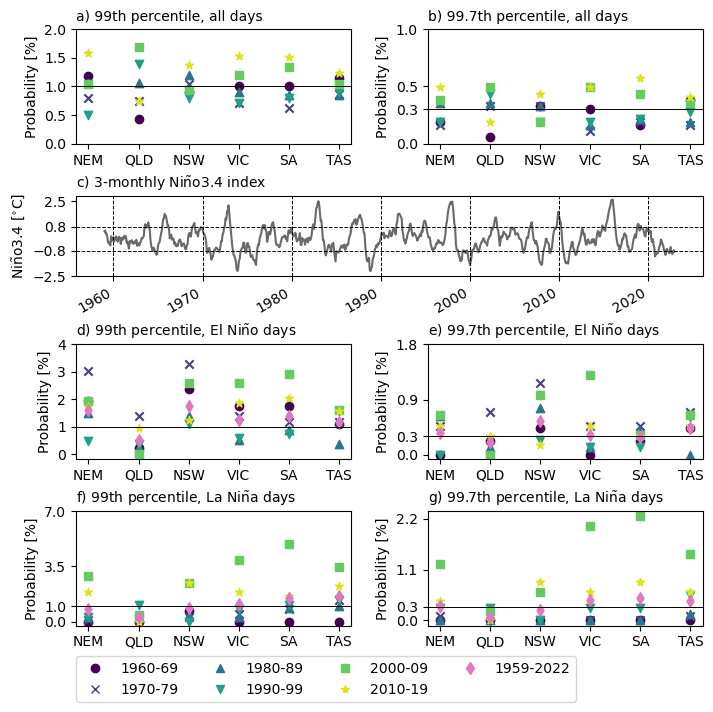

In [134]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 2, height_ratios=[1, 0.7, 1., 1., 0.1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,:])
# axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# All days
plot_decadal(ax1, t2m_probs_p99, ref_prob=1)
ax1.set_title("a) 99th percentile, all days", fontsize=10, loc="left")
ax1.set_yticks(np.arange(0, 2.01, 0.5))

plot_decadal(ax2, t2m_probs_p99_7, ref_prob=0.3)
ax2.set_title("b) 99.7th percentile, all days", fontsize=10, loc="left")
ax2.set_yticks([0, 0.3, 0.5, 1])

# Nino34
nino34_monthly.sel(time=slice("1959", "2022")).plot(ax=ax3, color="dimgray")
ax3.axhline(-0.8, c="k", lw=0.7, ls="--")
ax3.axhline(0.8, c="k", lw=0.7, ls="--")
ax3.set_yticks([-2.5, -0.8, 0.8, 2.5])
ax3.set_ylabel(r"Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]")
ax3.set_xlabel("")
ax3.set_title(r"c) 3-monthly Ni$\mathrm{\tilde{n}}$o3.4 index", fontsize=10, loc="left")
for d in range(1960, 2021, 10):
    ax3.axvline(pd.to_datetime(str(d) + "-01-01"), c="k", ls="--", lw=0.7)

# El Nino
plot_decadal(ax4, t2m_probs_p99_EN, plot_enso_ref_prob=True, ref_prob=1)
ax4.set_title(r"d) 99th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax4.set_yticks(range(5))

plot_decadal(ax5, t2m_probs_p99_7_EN, plot_enso_ref_prob=True, ref_prob=0.3)
ax5.set_title(r"e) 99.7th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax5.set_yticks([0, 0.3, 0.9, 1.8])

# La Nina
plot_decadal(ax6, t2m_probs_p99_LN, plot_enso_ref_prob=True, ref_prob=1)
ax6.set_title(r"f) 99th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax6.set_yticks([0, 1, 3.5, 7])

plot_decadal(ax7, t2m_probs_p99_7_LN, plot_enso_ref_prob=True, ref_prob=0.3)
p = ax7.set_title(r"g) 99.7th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax7.set_yticks([0, 0.3, 1.1, 2.2])

# Manual legend   
# col1 = Line2D([0], [0], marker='o', markeredgecolor="tab:blue", markerfacecolor="tab:blue", linestyle="")
# col2 = Line2D([0], [0], marker='x', markeredgecolor="tab:orange", markerfacecolor="tab:orange", linestyle="")
# col3 = Line2D([0], [0], marker='^', markeredgecolor="tab:green", markerfacecolor="tab:green", linestyle="")
# col4 = Line2D([0], [0], marker='v', markeredgecolor="tab:red", markerfacecolor="tab:red", linestyle="")
# col5 = Line2D([0], [0], marker='s', markeredgecolor="tab:purple", markerfacecolor="tab:purple", linestyle="")
# col6 = Line2D([0], [0], marker='*', markeredgecolor="tab:brown", markerfacecolor="tab:brown", linestyle="")
# col7 = Line2D([0], [0], marker='d', markeredgecolor="k", markerfacecolor="k", linestyle="")

cmap = matplotlib.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 0.95, 6)]
items = []
for i, marker in enumerate(["o", "x", "^", "v", "s", "*"]):
    color = colors[i]
    line = Line2D([0], [0], marker=marker, markeredgecolor=color, markerfacecolor=color, linestyle="")
    items.append(line)
items.append(Line2D([0], [0], marker='d', markeredgecolor="tab:pink", markerfacecolor="tab:pink", linestyle=""))

ax8.legend(
    # [col1, col2, col3, col4, col5, col6, col7],
    items,
    ["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19", "1959-2022"],
    loc=(0, 0),
    ncol=4,
    frameon=True
)
ax8.axis("off")

plt.savefig("figures/conditional_probabilities_t2m.pdf", format="pdf", bbox_inches="tight")

#### Difference in probabilities

In [135]:
diff_probs_p99 = {}
diff_probs_p99_7 = {}
diff_probs_p99_EN = {}
diff_probs_p99_7_EN = {}
diff_probs_p99_LN = {}
diff_probs_p99_7_LN = {}

for r in regions:
    diff_probs_p99[r] = {}
    diff_probs_p99_7[r] = {}
    
    diff_probs_p99_EN[r] = {}
    diff_probs_p99_7_EN[r] = {}
    
    diff_probs_p99_LN[r] = {}
    diff_probs_p99_7_LN[r] = {}
    
    diff_probs_p99[r]["split_probs"] = np.array(probs_p99[r]["split_probs"]) - np.array(t2m_probs_p99[r]["split_probs"])
    diff_probs_p99_7[r]["split_probs"] = np.array(probs_p99_7[r]["split_probs"]) - np.array(t2m_probs_p99_7[r]["split_probs"])
    
    diff_probs_p99_EN[r]["split_probs"] = np.array(probs_p99_EN[r]["split_probs"]) - np.array(t2m_probs_p99_EN[r]["split_probs"])
    diff_probs_p99_7_EN[r]["split_probs"] = np.array(probs_p99_7_EN[r]["split_probs"]) - np.array(t2m_probs_p99_7_EN[r]["split_probs"])
    diff_probs_p99_EN[r]["enso_ref_prob"] = probs_p99_EN[r]["enso_ref_prob"] - t2m_probs_p99_EN[r]["enso_ref_prob"]
    diff_probs_p99_7_EN[r]["enso_ref_prob"] = probs_p99_7_EN[r]["enso_ref_prob"] - t2m_probs_p99_7_EN[r]["enso_ref_prob"]
    
    diff_probs_p99_LN[r]["split_probs"] = np.array(probs_p99_LN[r]["split_probs"]) - np.array(t2m_probs_p99_LN[r]["split_probs"])
    diff_probs_p99_7_LN[r]["split_probs"] = np.array(probs_p99_7_LN[r]["split_probs"]) - np.array(t2m_probs_p99_7_LN[r]["split_probs"])
    diff_probs_p99_LN[r]["enso_ref_prob"] = probs_p99_LN[r]["enso_ref_prob"] - t2m_probs_p99_LN[r]["enso_ref_prob"]
    diff_probs_p99_7_LN[r]["enso_ref_prob"] = probs_p99_7_LN[r]["enso_ref_prob"] - t2m_probs_p99_7_LN[r]["enso_ref_prob"]
    

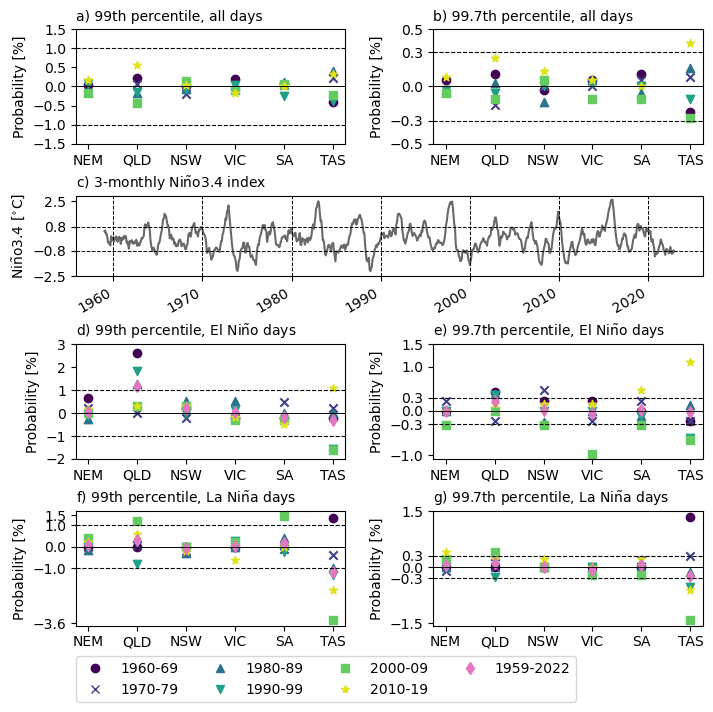

In [142]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 2, height_ratios=[1, 0.7, 1., 1., 0.1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,:])
# axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# All days
plot_decadal(ax1, diff_probs_p99, ref_prob=0)#, , ref_prob=1)
ax1.set_title("a) 99th percentile, all days", fontsize=10, loc="left")
ax1.set_yticks(np.arange(-1.5, 1.51, 0.5))

plot_decadal(ax2, diff_probs_p99_7, ref_prob=0)#, , ref_prob=0.3)
ax2.set_title("b) 99.7th percentile, all days", fontsize=10, loc="left")
ax2.set_yticks([-0.5, -0.3, 0, 0.3, 0.5])

# Nino34
nino34_monthly.sel(time=slice("1959", "2022")).plot(ax=ax3, color="dimgray")
ax3.axhline(-0.8, c="k", lw=0.7, ls="--")
ax3.axhline(0.8, c="k", lw=0.7, ls="--")
ax3.set_yticks([-2.5, -0.8, 0.8, 2.5])
ax3.set_ylabel(r"Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]")
ax3.set_xlabel("")
ax3.set_title(r"c) 3-monthly Ni$\mathrm{\tilde{n}}$o3.4 index", fontsize=10, loc="left")
for d in range(1960, 2021, 10):
    ax3.axvline(pd.to_datetime(str(d) + "-01-01"), c="k", ls="--", lw=0.7)

# El Nino
plot_decadal(ax4, diff_probs_p99_EN, plot_enso_ref_prob=True, ref_prob=0)#, , ref_prob=1)
ax4.set_title(r"d) 99th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax4.set_yticks(np.arange(-2, 3.01, 1))

plot_decadal(ax5, diff_probs_p99_7_EN, plot_enso_ref_prob=True, ref_prob=0)#, , ref_prob=0.3)
ax5.set_title(r"e) 99.7th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax5.set_yticks([-1, -0.3, 0, 0.3, 1, 1.5])

# La Nina
plot_decadal(ax6, diff_probs_p99_LN, plot_enso_ref_prob=True, ref_prob=0)#, , ref_prob=1)
ax6.set_title(r"f) 99th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax6.set_yticks([-3.6, -1, 0, 1, 1.5])

plot_decadal(ax7, diff_probs_p99_7_LN, plot_enso_ref_prob=True, ref_prob=0)#, ref_prob=0.3)
p = ax7.set_title(r"g) 99.7th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax7.set_yticks([-1.5, -0.3, 0, 0.3, 1.5])

for a in [ax1, ax4, ax6]:
    a.axhline(-1, c="k", ls="--", lw=0.8)
    a.axhline(1, c="k", ls="--", lw=0.8)
for a in [ax2, ax5, ax7]:
    a.axhline(-0.3, c="k", ls="--", lw=0.8)
    a.axhline(0.3, c="k", ls="--", lw=0.8)

# Manual legend   
# col1 = Line2D([0], [0], marker='o', markeredgecolor="tab:blue", markerfacecolor="tab:blue", linestyle="")
# col2 = Line2D([0], [0], marker='x', markeredgecolor="tab:orange", markerfacecolor="tab:orange", linestyle="")
# col3 = Line2D([0], [0], marker='^', markeredgecolor="tab:green", markerfacecolor="tab:green", linestyle="")
# col4 = Line2D([0], [0], marker='v', markeredgecolor="tab:red", markerfacecolor="tab:red", linestyle="")
# col5 = Line2D([0], [0], marker='s', markeredgecolor="tab:purple", markerfacecolor="tab:purple", linestyle="")
# col6 = Line2D([0], [0], marker='*', markeredgecolor="tab:brown", markerfacecolor="tab:brown", linestyle="")
# col7 = Line2D([0], [0], marker='d', markeredgecolor="k", markerfacecolor="k", linestyle="")

cmap = matplotlib.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 0.95, 6)]
items = []
for i, marker in enumerate(["o", "x", "^", "v", "s", "*"]):
    color = colors[i]
    line = Line2D([0], [0], marker=marker, markeredgecolor=color, markerfacecolor=color, linestyle="")
    items.append(line)
items.append(Line2D([0], [0], marker='d', markeredgecolor="tab:pink", markerfacecolor="tab:pink", linestyle=""))

ax8.legend(
    # [col1, col2, col3, col4, col5, col6, col7],
    items,
    ["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19", "1959-2022"],
    loc=(0, 0),
    ncol=4,
    frameon=True
)
ax8.axis("off")

plt.savefig("figures/conditional_probabilities_diff.pdf", format="pdf", bbox_inches="tight")

### Time series of extreme demand days

In [76]:
def normalise(da, period=slice(None, None), dim="time"):
    """
    Normalise by removing mean and dividing by standard deviation
    """
    return (da - da.sel({dim: period}).mean(dim)) / da.sel({dim: period}).std(dim)

In [77]:
def extreme_days(da, q, period=slice(None, None), dim="time"):
    """
    Days above q, where q is computed over period
    """
    thresh = da.sel({dim: period}).quantile(q, dim)
    return da.where(da > thresh)

In [78]:
def plot_2d_series(ax, da, title):
    """
    Plot 2d time series
    """
    da.assign_coords({"region": range(6)}).plot(ax=ax)
    ax.set_yticks(range(6))
    ax.set_yticklabels(regions)
    ax.invert_yaxis()
    ax.set_title(title)

In [79]:
demand = xr.concat(
    [pred_ds[r]["demand"].expand_dims({"region": [r]}) for r in regions],
    "region"
)

In [80]:
baseline = slice("1990", "2019")

In [81]:
q = 1 - 1 / (365 * 1)
print(q)

0.9972602739726028


In [82]:
ext_dpy = extreme_days(demand, q, baseline).resample(time="1YS").count()

In [83]:
ext_dpy.sum("time")

<xarray.DataArray 'demand' (region: 6)>
array([51, 50, 55, 49, 49, 53])
Coordinates:
  * region    (region) object 'NEM' 'QLD' 'NSW' 'VIC' 'SA' 'TAS'
    quantile  float64 0.9973

In [84]:
# Normalised annual mean demand
norm_mean = normalise(demand, baseline).resample(time="1YS").mean()

In [85]:
# Normalised annual maximum demand
norm_max = normalise(demand, baseline).resample(time="1YS").max()

In [86]:
# Monthly occurrences of extreme days
monthly_ext = extreme_days(demand, q, baseline).sel(time=baseline).groupby("time.month").count()

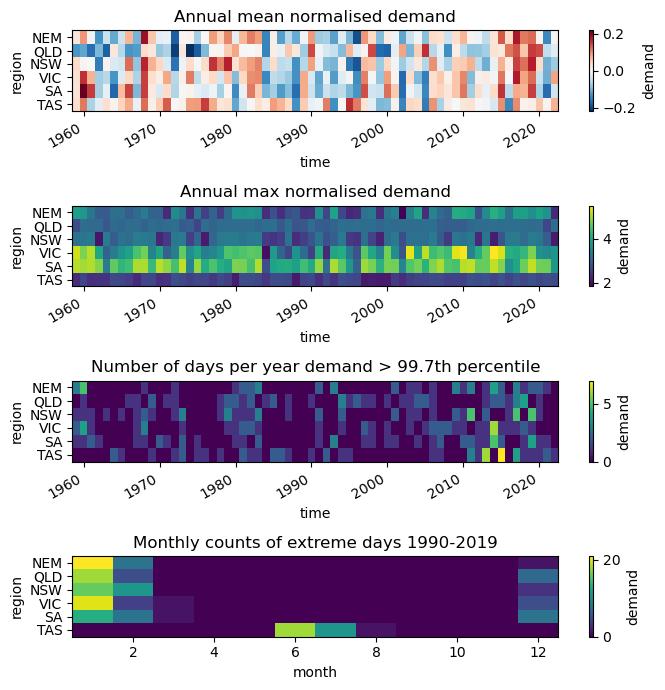

In [87]:
fig, ax = plt.subplots(4, 1, figsize=(7, 7.))

plot_2d_series(ax[0], norm_mean, "Annual mean normalised demand")
plot_2d_series(ax[1], norm_max, "Annual max normalised demand")
plot_2d_series(ax[2], ext_dpy,
               "Number of days per year demand > " + str(np.round(q*100, 1)) + "th percentile"
              )
plot_2d_series(ax[3], monthly_ext, "Monthly counts of extreme days 1990-2019")
plt.tight_layout()

### Max demand on record

In [60]:
def get_days_around(date, n_before, n_after):
    """
    Return dates around a given date
    """
    return pd.date_range(date + pd.DateOffset(days=-n_before), date + pd.DateOffset(days=n_after), freq="D")

In [61]:
def normalise_monthly(da, dims=["time"], period=None):
    """
    Normalise monthly with respect to period (a slice object)
    """
    if period == None:
        return da.groupby("time.month").apply(lambda x: (x - x.mean(dims)) / x.std(dims))
    else:
        return da.sel({"time": period}).groupby("time.month").apply(lambda x: (x - x.mean(dims)) / x.std(dims))

In [62]:
def anomalise_monthly(da, dims=["time"], period=None):
    """
    Anomalise monthly with respect to period (a slice object)
    """
    if period == None:
        return da.groupby("time.month").apply(lambda x: x - x.mean(dims))
    else:
        return da.sel({"time": period}).groupby("time.month").apply(lambda x: x - x.mean(dims))

In [63]:
def plot_max(demand_da, roll, predictors_ds, normalise, days_before, days_after, var_axis_offset, ylabels, suptitle):
    """
    Plot maximum demand for a given averaging period.
    
    demand_da: array of demand
    roll: int, average to take mean over
    predictors_ds: dataset of predictors
    normalise: bool, whether to normalise demand and predictors
    days_before, days_after: int, days around maximum to plot
    var_axis_offset: dict in format k: [ax, offset], where k is the index of the variable,
        ax is the axis index on which to plot this variable, and offset is the value to add.
        If you don't want to plot a variable, set the value to None.
    ylabels: list, ylabels
    suptitle: figure title
    """
    demand_da = demand_da / 1000
    dem_roll = demand_da.rolling(time=roll).mean()
    
    if normalise:
        demand_da = normalise_monthly(demand_da)
        dem_roll = normalise_monthly(dem_roll)
    
    dem_max = dem_roll.idxmax("time")
    days_around = get_days_around(dem_max.values, days_before, days_after)
    
    dem_roll_sel = dem_roll.sel(time=days_around)
    dem_sel = demand_da.sel(time=days_around)
    
    preds = list(predictors_ds.data_vars)[:-1]
    print(preds)
    preds_data = [predictors_ds[preds[i]].sel(time=days_around) for i in range(len(preds))]
    
    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(7,4))
    
    dem_sel.plot(ax=ax[0,0], label="Daily")
    dem_roll_sel.plot(ax=ax[0,0], label=str(roll) + "-day")
    ax[0,0].set_title("")
    
    for i, var in enumerate(preds):
        if var_axis_offset[i] is not None:
            (preds_data[i] + var_axis_offset[i][0]).plot(ax=ax.flatten()[var_axis_offset[i][1]], label=preds[i])
        
    for i, a in enumerate(ax.flatten()):
        a.axvline(dem_max.values, c="k")
        a.legend(loc=[0,1], ncols=2, frameon=False)
        a.set_ylabel(ylabels[i])
        a.set_xlabel("")
        a.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(a.xaxis.get_major_locator()))#.DateFormatter('%Y-%m-%d'))
        
    plt.suptitle(suptitle, y=0.95)
    # plt.subplots_adjust(wspace=0.3, hspace=1.)
    plt.tight_layout()

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


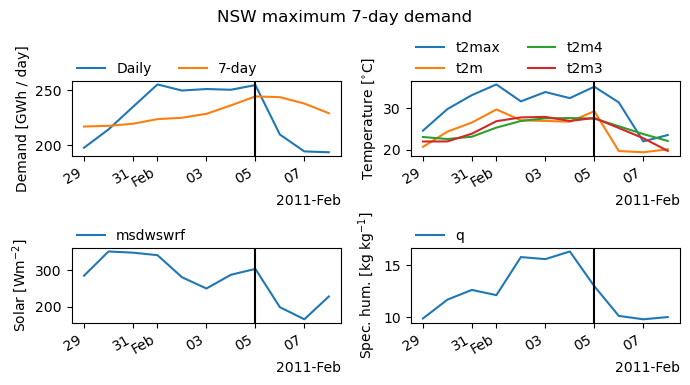

In [64]:
plot_max(
    demand.sel(region="NSW"),
    7,
    pred_ds["NSW"],
    False,
    7,
    3,
    {
        0: [-273.15, 1],
        2: [-273.15, 1],
        5: [-273.15, 1],
        6: [-273.15, 1],
        1: [0, 2],
        3: [0, 3],
        4: None
    },
    ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Spec. hum. [kg kg$^{-1}$]"],
    "NSW maximum 7-day demand"
)

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


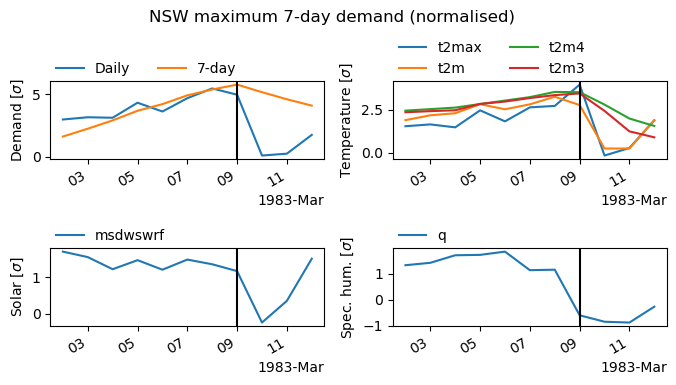

In [65]:
plot_max(
    normalise_monthly(demand.sel(region="NSW")),
    7,
    normalise_monthly(pred_ds["NSW"]),
    True,
    7,
    3,
    {
        0: [0, 1],
        2: [0, 1],
        5: [0, 1],
        6: [0, 1],
        1: [0, 2],
        3: [0, 3],
        4: None
    },
    [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Spec. hum. [$\sigma$]"],
    "NSW maximum 7-day demand (normalised)"
)

### Composite evolution on extreme days

In [66]:
def get_cases(da, times, days_before, days_after):
    """
    Return an array that selects and reshapes da according to times provided, 
    with some days prior and after each time.
    """
    da_list = []
    for time in times:
        days_around = get_days_around(time, days_before, days_after)
        idx_days_around = range(-days_before, days_after+1)
        
        _da = da.sel(time=days_around)
        _da = _da.rename({"time": "days_around"})
        _da = _da.assign_coords({"days_around": idx_days_around})
        _da = _da.expand_dims({"time": [time]})
        da_list.append(_da)
    return xr.concat(da_list, "time")

In [67]:
def subset_events(da, window):
    """
    Returns last times from da that fall within a window.
    E.g. if you want events that occur within a week to be a single event,
    set window=7.
    """
    days_diff = da["time"].to_series().diff().dt.days # difference between days
    mask = days_diff < window # where dys fall within the window
    group = (~mask).cumsum() # Assign groups to events
    events = days_diff.groupby(group).tail(1) # final day of event    
    return da.sel(time=events.index) # Select events of da

In [68]:
def get_events_data(predictors_ds, roll, q, days_before, days_after, event_window, normalise=False):
    """
    Return demand and predictor data for extreme events, plus days either side
    
    predictors_ds: dataset of demand and predictors
    roll: moving average length to determine extreme events
    q: extreme event threshold
    days_before, days_after: days around event
    event_window: threshold to exclude consecutive days from being individual events
    normalise: bool, whether to normalise data before finding events
    """ 
    ext_dict = {}
    for r in regions:
        # Moving average of demand data. This is used to compute extreme events
        demand_roll = predictors_ds[r]["demand"].rolling(time=roll).mean()

        # Get dates of events
        dem_ext = extreme_days(demand_roll, q=q) # Days above q
        dem_ext = dem_ext.dropna("time")
        dem_events = subset_events(dem_ext, event_window) # Don't count days within a window
        
        if normalise:
            # Get dates of events before normalising
            dem_ext = extreme_days(demand_roll, q=q) # Days above q
            dem_ext = dem_ext.dropna("time")
            dem_events = subset_events(dem_ext, event_window) # Don't count days within a window
            
            # Now normalise
            demand_roll = normalise_monthly(demand_roll)
            preds = normalise_monthly(predictors_ds[r])
        else:
            preds = predictors_ds[r]
       

        # Extract events from da
        ext_dict[r] = get_cases(
            demand_roll,
            dem_events["time"].values,
            days_before,
            days_after
        ).to_dataset(name="demand_" + str(roll))

        # Repeat for all predictors
        data_vars = list(preds.data_vars)
        for name in data_vars:
            da = preds[name]

            var_cases = get_cases(
                da,
                dem_events["time"].values,
                days_before,
                days_after
            )

            ext_dict[r][name] = var_cases
            
    return ext_dict

In [69]:
def get_event_plot_params():
    """
    Returns a nested dict of plotting parameters for event plots
    """
    plot_params = {
        "original": {},
        "normalised": {}
    }
    
    plot_params["original"]["NEM"] = {
        "data": events_dict["NEM"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            3: [0, 2, "tab:purple"],
            5: [0, 2, "tab:pink"],
            1: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None,
            7: None,
            8: None,
            9: None,
            10: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Degree day [$^{\circ}$C]", r"Solar [Wm$^{-2}$]"],
        "suptitle": "NEM extreme " + str(roll) + "-day demand (" + str(len(events_dict["NEM"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["NEM"] = {
        "data": norm_events_dict["NEM"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            3: [0, 2, "tab:purple"],
            5: [0, 2, "tab:pink"],
            1: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None,
            7: None,
            8: None,
            9: None,
            10: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Degree day [$\sigma$]", r"Solar [$\sigma$]"],
        "suptitle": "NEM extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["NEM"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["QLD"] = {
        "data": events_dict["QLD"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            5: [-273.15, 1, "tab:purple"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"CDD [$^{\circ}$C]"],
        "suptitle": "QLD extreme " + str(roll) + "-day demand (" + str(len(events_dict["QLD"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["QLD"] = {
        "data": norm_events_dict["QLD"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            5: [0, 1, "tab:purple"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"CDD [$\sigma$]"],
        "suptitle": "QLD extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["QLD"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["NSW"] = {
        "data": events_dict["NSW"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            5: [-273.15, 1, "tab:purple"],
            6: [-273.15, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Spec. hum. [kg kg$^{-1}$]"],
        "suptitle": "NSW extreme " + str(roll) + "-day demand (" + str(len(events_dict["NSW"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["NSW"] = {
        "data": norm_events_dict["NSW"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            5: [0, 1, "tab:purple"],
            6: [0, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Spec. hum. [$\sigma$]"],
        "suptitle": "NSW extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["NSW"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["VIC"] = {
        "data": events_dict["VIC"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            5: [-273.15, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Wind speed [ms$^{-1}$]"],
        "suptitle": "VIC extreme " + str(roll) + "-day demand (" + str(len(events_dict["VIC"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["VIC"] = {
        "data": norm_events_dict["VIC"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            5: [0, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Wind speed [$\sigma$]"],
        "suptitle": "VIC extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["VIC"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["SA"] = {
        "data": events_dict["SA"],
        "details": {
            0: [-273.15, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            5: None,
            6: None,
            7: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"HDD [$^{\circ}$C]"],
        "suptitle": "SA extreme " + str(roll) + "-day demand (" + str(len(events_dict["SA"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["SA"] = {
        "data": norm_events_dict["SA"],
        "details": {
            0: [0, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            5: None,
            6: None,
            7: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"HDD [$\sigma$]"],
        "suptitle": "SA extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["SA"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["TAS"] = {
        "data": events_dict["TAS"],
        "details": {
            0: [0, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
        },
        "ylabels": ["Demand [GWh / day]", r"Solar [Wm$^{-2}$]", r"HDD [$^{\circ}$C]", r"Wind speed [ms$^{-1}$]"],
        "suptitle": "TAS extreme " + str(roll) + "-day demand (" + str(len(events_dict["TAS"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["TAS"] = {
        "data": norm_events_dict["TAS"],
        "details": {
            0: [0, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
        },
        "ylabels": ["Demand [$\sigma$]", r"Solar [$\sigma$]", r"HDD [$\sigma$]", r"Wind speed [$\sigma$]"],
        "suptitle": "TAS extreme " + str(roll) + "-day demand (" + str(len(norm_events_dict["TAS"].time.values)) + " events)",
        "GWh": False
    }
    
    return plot_params

In [70]:
from matplotlib.lines import Line2D

In [71]:
def plot_events(ds, axis_details, ylabels, suptitle, plot_range=False, to_GWh=False, plot_zero=False):
    """
    Plot maximum demand for a given averaging period.
    
    ds: dataset of demand and predictors for events
    axis_details: dict in format k: [ax, offset, color], where k is the index of the variable,
        ax is the axis index on which to plot this variable, offset is the value to add,
        and color is the line color.
        If you don't want to plot a variable, set the value to None.
    ylabels: list, ylabels
    suptitle: figure title
    plot_range: plot range of data rather than all lines
    to_GWh: bool, whether to divide demand arrays by 1000
    plot_zero: bool, whether or not to plot y=0
    """
    def _plot_lines(ax, da, color, label):
        p = da.plot.line(ax=ax, x="days_around", c=color, label=label, add_legend=False, lw=1)
    def _plot_range(ax, da, color, label):
        ax.fill_between(da.days_around, da.min("time"), da.max("time"), color=color, alpha=0.3)
        p = ax.plot(da.days_around, da.mean("time"), color=color)
        
    data_vars = list(ds.data_vars)
    
    fig, ax = plt.subplots(2, 2, figsize=(7,4))
    
    demand = ds["demand"]
    demand_roll = ds[data_vars[0]]
    if to_GWh:
        demand = ds["demand"] / 1000
        demand_roll = ds[data_vars[0]] / 1000
        
    if plot_range:
        _plot_range(ax[0,0], demand, "lightgray", "Daily")
        _plot_range(ax[0,0], demand_roll, "k", data_vars[0].split("_")[1] + "-day")
    else:
        _plot_lines(ax[0,0], demand, "lightgray", "Daily")
        _plot_lines(ax[0,0], demand_roll, "k", data_vars[0].split("_")[1] + "-day")
    
    # Legend colors and labels as a list of lists (one list per panel)
    legend_colors = [
        ["lightgray", "k"],
        [],
        [],
        []
    ]
    legend_handles = [
        ["Daily", data_vars[0].split("_")[1] + "-day"],
        [],
        [],
        []
    ]

    ax[0,0].set_title("")
    
    print(data_vars[1:-1])
    for i, var in enumerate(data_vars[1:-1]):
        if axis_details[i] is not None:
            da = ds[var] + axis_details[i][0]
            
            if plot_range:
                _plot_range(ax.flatten()[axis_details[i][1]], da, axis_details[i][2], var)
            else:
                _plot_lines(ax.flatten()[axis_details[i][1]], da, axis_details[i][2], var)
                
            legend_colors[axis_details[i][1]].append(axis_details[i][2])
            legend_handles[axis_details[i][1]].append(var)
        
    for i, a in enumerate(ax.flatten()):
        a.axvline(0, c="k", ls="--")
        a.set_title("")
        a.set_ylabel(ylabels[i])
        a.set_xlabel("")
        if plot_zero:
            a.axhline(0, c="k", ls="--")
        
        # Custom legend
        lines = [Line2D([0], [0], color=c) for c in legend_colors[i]]
        a.legend(lines, legend_handles[i], loc=(0, 1), ncol=2, frameon=False)
            
    plt.suptitle(suptitle, y=0.95)
    # plt.subplots_adjust(wspace=0.3, hspace=1.)
    plt.tight_layout()
    
    # return fig

In [72]:
roll = 7
days_before = 10
days_after = 3
event_window = 7
q = 1 - 1 / (365 * 3)
print(q)

0.9990867579908675


In [73]:
events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window)

In [74]:
norm_events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window, True)

In [75]:
event_plot_params = get_event_plot_params()

In [76]:
for data_type in ["original", "normalised"]:
    
    if data_type == "normalised":
        plot_zero = True
    else:
        plot_zero = False
        
    for plot_range in [False, True]:
        for r in regions:

            plot_events(
                event_plot_params[data_type][r]["data"],
                event_plot_params[data_type][r]["details"],
                event_plot_params[data_type][r]["ylabels"],
                event_plot_params[data_type][r]["suptitle"],
                plot_range=plot_range,
                to_GWh=event_plot_params[data_type][r]["GWh"],
                plot_zero=plot_zero
            )

            fp = "./figures/extreme_" + str(roll) + "day_events_" + r + "_" + data_type
            if plot_range:
                fp += "_range"

            plt.savefig(fp + "_detrended.pdf", format="pdf", bbox_inches="tight")
            plt.close()

['t2max', 'msdwswrf', 't2m', 'w10', 'cdd', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2min', 't2m4']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 'q', 'w10', 'cdd', 't2min', 't2m3']
['msdwswrf', 't2m', 'w10', 'rh', 't2m3']
['t2max', 'msdwswrf', 't2m', 'w10', 'cdd', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2min', 't2m4']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 'q', 'w10', 'cdd', 't2min', 't2m3']
['msdwswrf', 't2m', 'w10', 'rh', 't2m3']
['t2max', 'msdwswrf', 't2m', 'w10', 'cdd', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2min', 't2m4']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 'q', 'w10', 'cdd', 't2min', 't2m3']
['msdwswrf', 't2m', 'w10', 'rh', 't2m3']
['t2max', 

### Color by season

In [63]:
def plot_season_events(ds, axis_details, ylabels, suptitle, plot_range=False, to_GWh=False, plot_zero=False):
    """
    Plot maximum demand for a given averaging period.
    
    ds: dataset of demand and predictors for events
    axis_details: dict in format k: [ax, offset, color], where k is the index of the variable,
        ax is the axis index on which to plot this variable, offset is the value to add,
        and color is the line color.
        If you don't want to plot a variable, set the value to None.
    ylabels: list, ylabels
    suptitle: figure title
    plot_range: plot range of data rather than all lines
    to_GWh: bool, whether to divide demand arrays by 1000
    plot_zero: bool, whether or not to plot y=0
    """
    def _plot_lines(ax, da, color, label):
        da.plot.line(ax=ax, x="days_around", c=color, label=label, add_legend=False, lw=1)
    def _plot_range(ax, da, color, label):
        ax.fill_between(da.days_around, da.min("time"), da.max("time"), color=color, alpha=0.3)
        ax.plot(da.days_around, da.mean("time"), color=color)
        
    def _sel_winter(da):
        return da.where(da.time.dt.month.isin([4, 5, 6, 7, 8, 9]))
    def _sel_summer(da):
        return da.where(da.time.dt.month.isin([10, 11, 12, 1, 2, 3]))
        
    data_vars = list(ds.data_vars)
    
    fig, ax = plt.subplots(2, 2, figsize=(7,4))
    
    demand = ds["demand"]
    demand_roll = ds[data_vars[0]]
    if to_GWh:
        demand = ds["demand"] / 1000
        demand_roll = ds[data_vars[0]] / 1000
        
    if plot_range:
        _plot_range(ax[0,0], _sel_winter(demand_roll), "tab:blue", "Winter")
        _plot_range(ax[0,0], _sel_summer(demand_roll), "tab:orange", "Summer")
    else:
        _plot_lines(ax[0,0], _sel_winter(demand_roll), "tab:blue", "Winter")
        _plot_lines(ax[0,0], _sel_summer(demand_roll), "tab:orange", "Summer")

    ax[0,0].set_title("")
    
    lines = [Line2D([0], [0], color=c) for c in ["tab:blue", "tab:orange"]]
    ax[0,0].legend(lines, ["Winter", "Summer"], loc=(0, 1), ncol=2, frameon=False)
    
    print(data_vars[1:-1])
    for i, var in enumerate(data_vars[1:-1]):
        if axis_details[i] is not None:
            da = ds[var] + axis_details[i][0]
            
            if plot_range:
                _plot_range(ax.flatten()[axis_details[i][1]], _sel_winter(da), "tab:blue", var)
                _plot_range(ax.flatten()[axis_details[i][1]], _sel_summer(da), "tab:orange", var)
            else:
                _plot_lines(ax.flatten()[axis_details[i][1]], _sel_winter(da), "tab:blue", var)
                _plot_lines(ax.flatten()[axis_details[i][1]], _sel_summer(da), "tab:orange", var)
                
            ax.flatten()[axis_details[i][1]].set_title(var)
        
    for i, a in enumerate(ax.flatten()):
        a.axvline(0, c="k", ls="--")
        # a.set_title("")
        # a.legend(loc=[0,1], ncols=2, frameon=False)
        a.set_ylabel(ylabels[i])
        a.set_xlabel("")
        if plot_zero:
            a.axhline(0, c="k", ls="--")
        # a.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(a.xaxis.get_major_locator()))#.DateFormatter('%Y-%m-%d'))
                
    plt.suptitle(suptitle, y=0.95)
    # plt.subplots_adjust(wspace=0.3, hspace=1.)
    plt.tight_layout()

In [64]:
roll = 14
days_before = 14
days_after = 3
event_window = 7
q = 1 - 1 / (365 * 3)
print(q)

0.9990867579908675


In [65]:
events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window)

In [66]:
norm_events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window, True)

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


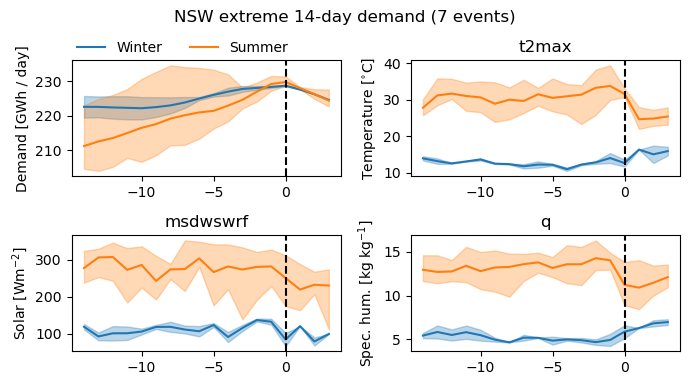

In [67]:
plot_season_events(
    events_dict["NSW"],
    {
        0: [-273.15, 1, "gray"],
        2: None,#[0, 1, "tab:blue"],
        5: None,#[0, 1, "tab:purple"],
        6: None,#[0, 1, "tab:pink"],
        1: [0, 2, "gray"],
        3: [0, 3, "gray"],
        4: None
    },
    ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Spec. hum. [kg kg$^{-1}$]"],
    "NSW extreme " + str(roll) + "-day demand (" + str(len(events_dict["NSW"].time.values)) + " events)",
    plot_range=True,
    to_GWh=True
)

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


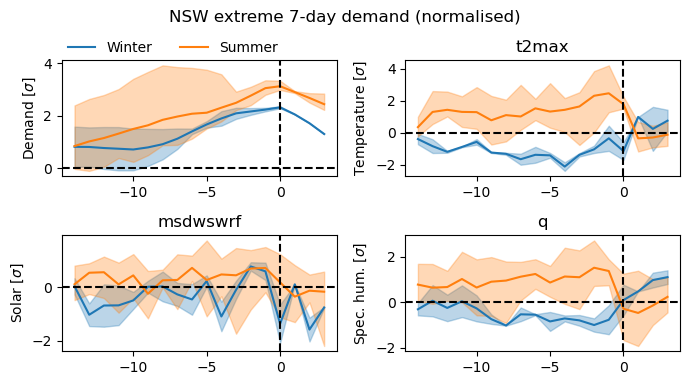

In [68]:
plot_season_events(
    norm_events_dict["NSW"],
    {
        0: [0, 1, "gray"],
        2: None,#[0, 1, "tab:blue"],
        5: None,#[0, 1, "tab:purple"],
        6: None,#[0, 1, "tab:pink"],
        1: [0, 2, "gray"],
        3: [0, 3, "gray"],
        4: None
    },
    [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Spec. hum. [$\sigma$]"],
    "NSW extreme 7-day demand (normalised)",
    True,
    False,
    plot_zero=True
)